# Modelo de Identificação de Fraudes

- Informações da base:
    - 'Time' (tempo): contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados. 
    - 'Amount' (valor): é o valor da transação 
    - 'Class' (classe): é a variável de resposta e assume valor 1 em caso de fraude e 0 caso contrário.
    - "Infelizmente, devido a questões de confidencialidade, não podemos fornecer os recursos originais e mais informações básicas sobre os dados. Características V1, V2, … V28 são os principais componentes obtidos com PCA"

In [1]:
# Configuração do ambiente

# Garante que o notebook está na raiz do projeto
%cd .. 

# Verifica o diretório atual (Linux/Mac)
# !pwd  

# Verifica o diretório atual (Windows)
!cd 

C:\Users\flavi\Documents\GitHub\Projeto_4_Modelo_de_Identificacao_de_Fraude
C:\Users\flavi\Documents\GitHub\Projeto_4_Modelo_de_Identificacao_de_Fraude


In [2]:
# Importações necessárias 

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import xgboost as xgb

from scipy.stats import kstest, normaltest, anderson

from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN

from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score,
    precision_recall_curve,
)

import warnings
from src.config.paths import DADOS_CREDICARD, DADOS_CREDICARD_TRATADO
from src.config.auxiliares_ml import downcast_dataframe, testar_modelos_com_undersampling

warnings.filterwarnings('ignore')
sns.set_theme(palette="bright")

In [3]:
# Importando a base

transacoes = pd.read_parquet(DADOS_CREDICARD_TRATADO)

In [4]:
# Verificar se todos os valores podem ser convertidos para inteiro (sem valores decimais)

if (transacoes['Time'] == transacoes['Time'].astype(int)).all():
    
    # Se todos os valores são inteiros, realizar a conversão
    
    transacoes['Time'] = transacoes['Time'].astype(int)
   
else:
    print("Nem todos os valores na coluna 'Time' podem ser convertidos para inteiro.")

In [5]:
# Visualizando as informações após alterar o tipo de 'Time'

transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  int64  
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [6]:
# Visualizando a estatística descritiva

transacoes.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.339397e-08,0.000000,-4.800400e-08,6.643411e-09,2.657364e-08,-1.500125e-09,-1.071518e-09,-1.071518e-10,-3.214554e-10,...,-1.928732e-09,3.643161e-09,3.214554e-10,1.259033e-09,2.143036e-09,1.034684e-09,1.138488e-10,-1.272427e-10,88.349619,0.001727
std,47488.145955,1.958611e+00,1.651183,1.516203e+00,1.415832e+00,1.380180e+00,1.332214e+00,1.237020e+00,1.194202e+00,1.098575e+00,...,7.344701e-01,7.256873e-01,6.244100e-01,6.056016e-01,5.212620e-01,4.822155e-01,4.035722e-01,3.300574e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-72.715729,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-0.598550,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,0.065486,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097605e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,0.803724,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273458e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,22.057730,9.382559e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519588e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Observando o quanto o target 'Class' está em desequilíbrio

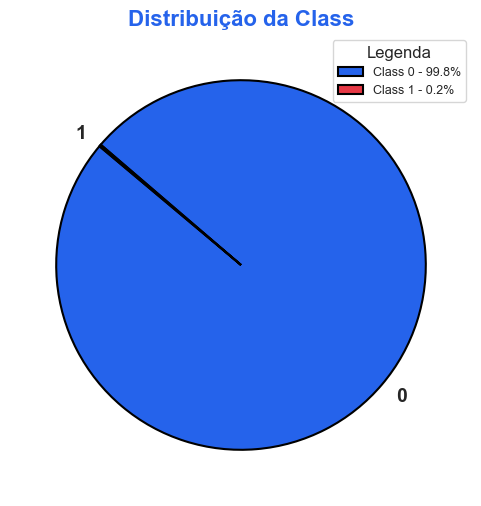

In [7]:
# Aplicando o tema do Seaborn com fundo cinza claro

sns.set_theme(style="whitegrid", palette="bright")

# Contagem dos valores na coluna 'Class'

class_counts = transacoes['Class'].value_counts()
labels = class_counts.index
sizes = class_counts.values

# Definir cores personalizadas (azul para Class 0 e vermelho para Class 1)
# Mantendo o azul original para Class 0 e usando vermelho para Class 1

colors = ['#2563EB' if label == 0 else '#E63946' for label in labels]  # Azul para 0, vermelho para 1

# Criando o gráfico de pizza com Seaborn e Matplotlib

plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='', colors=colors,
    startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, 
    textprops={'fontsize': 14, 'weight': 'bold'}
)

# Criando a legenda com as porcentagens

percentages = [f"{sizes[i] / sum(sizes) * 100:.1f}%" for i in range(len(sizes))]
legend_labels = [f"Class {labels[i]} - {percentages[i]}" for i in range(len(labels))]
plt.legend(wedges, legend_labels, title="Legenda", loc="best", fontsize=9)

plt.title("Distribuição da Class", fontsize=16, fontweight="bold", color='#2563EB')
plt.show()

### Observando se há presença de outliers

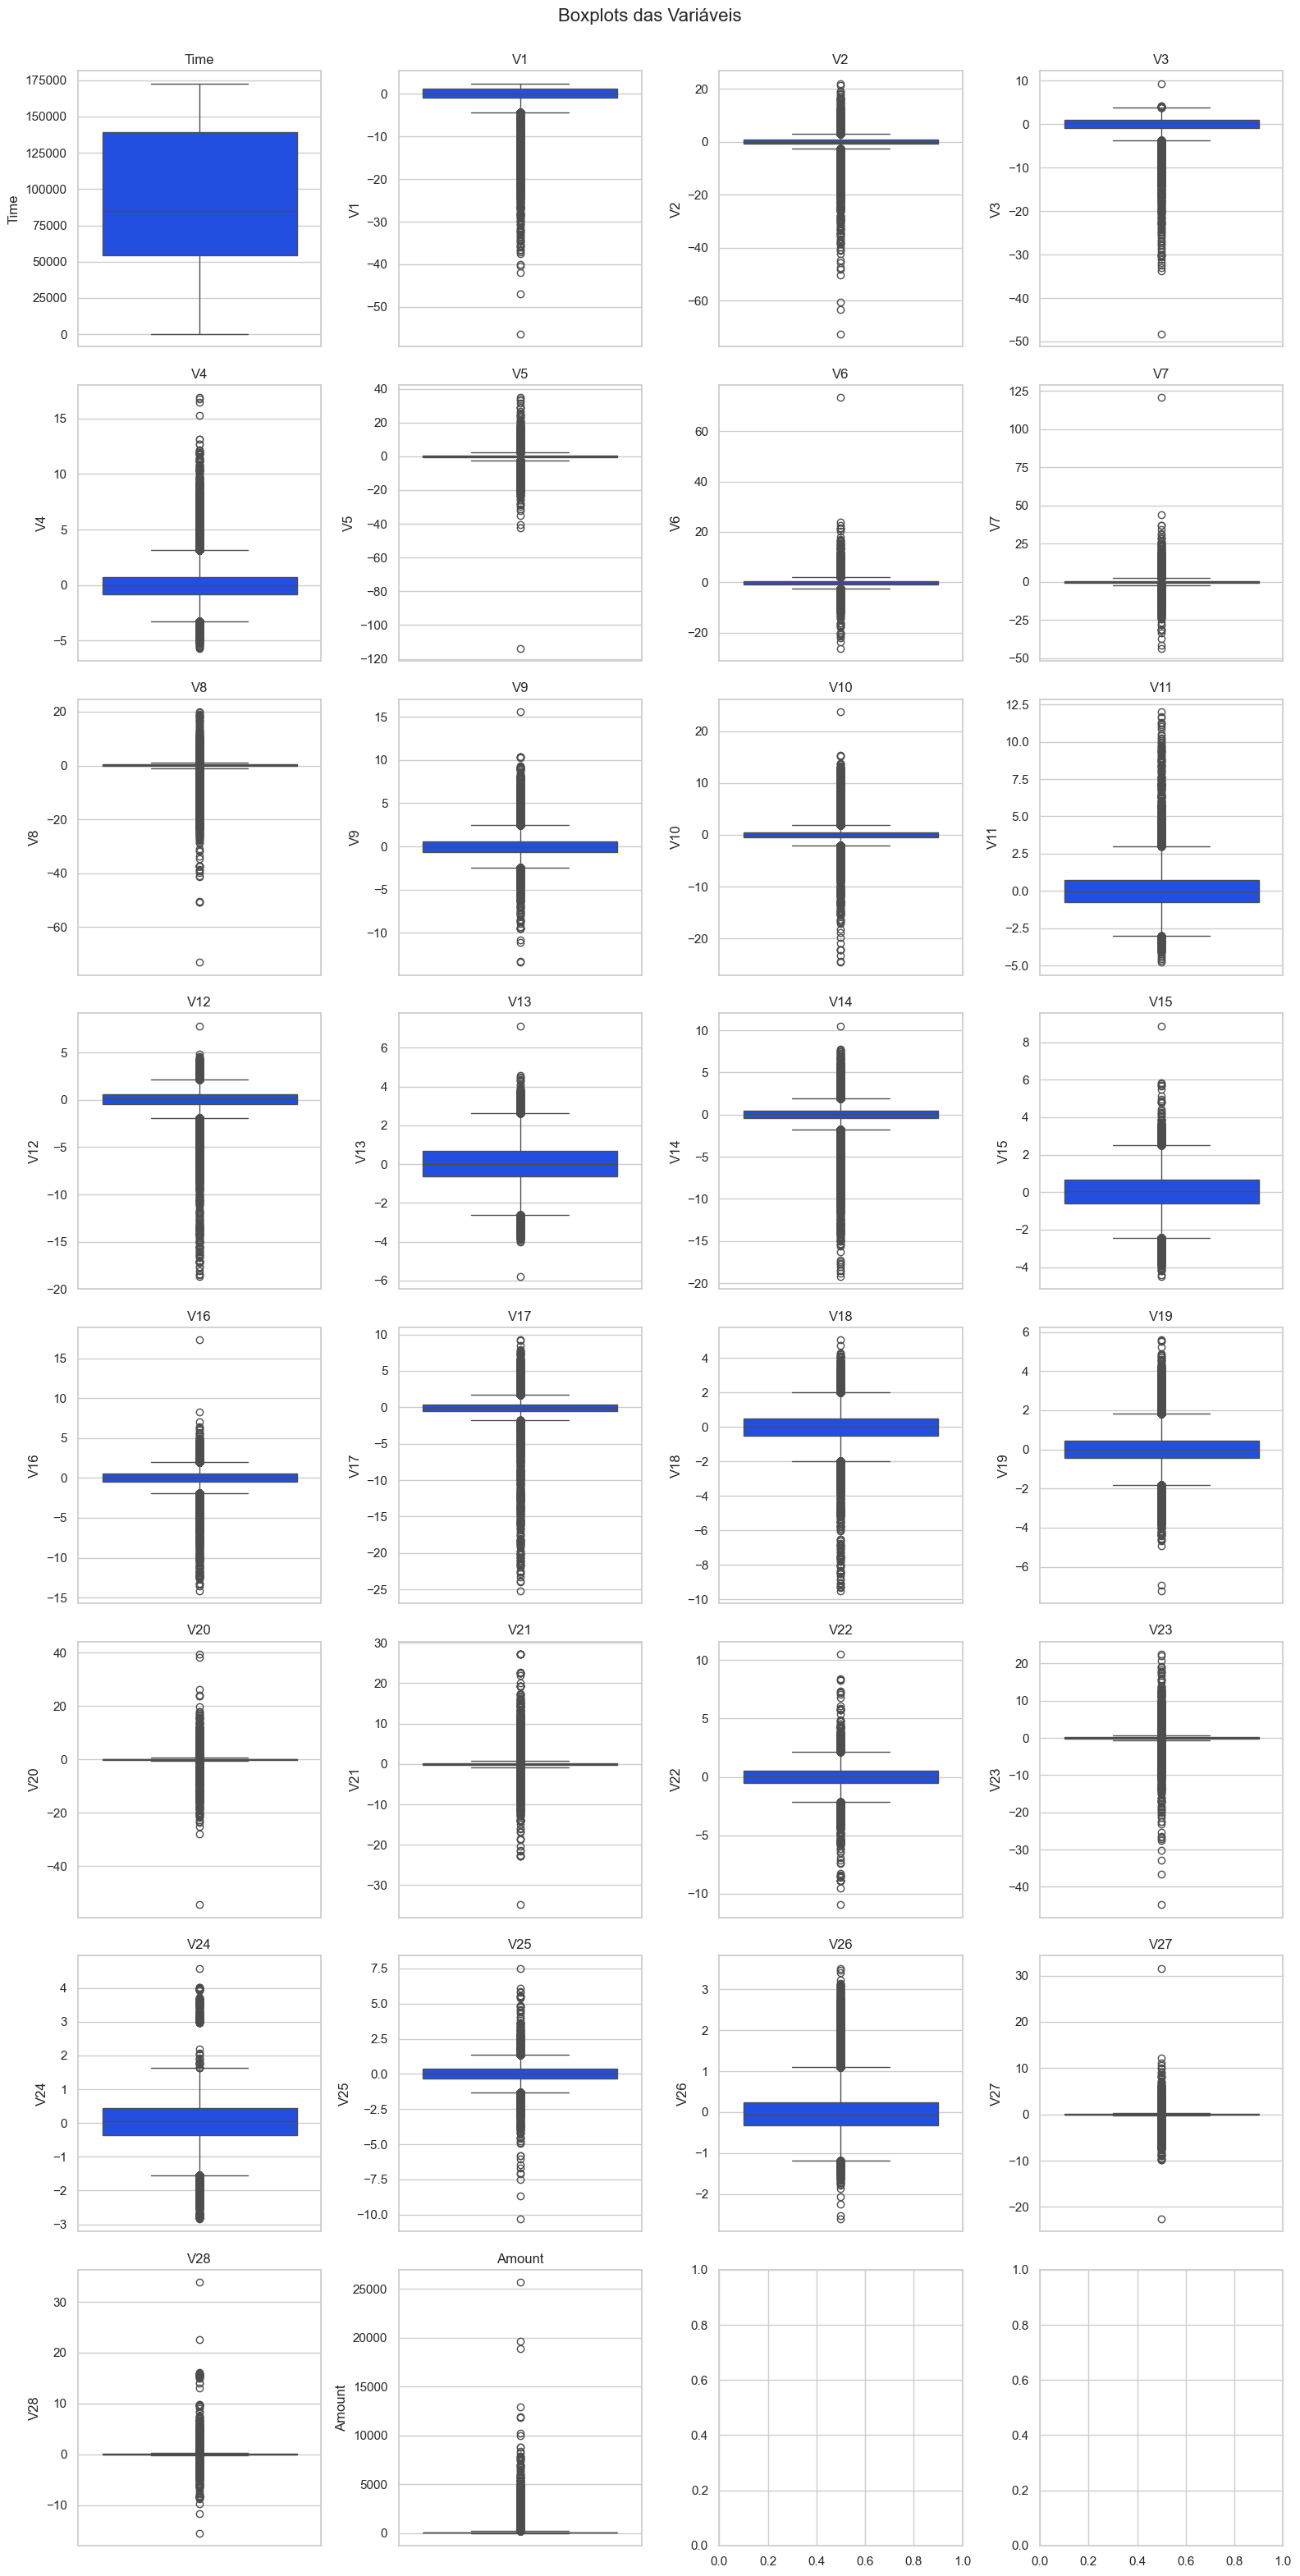

In [8]:
# Removendo 'Time' e 'Class', pois normalmente não são usados em análise de variáveis contínuas

features = [col for col in transacoes.columns if col not in ['Class']]

# Configuração do layout

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(16, 32))
fig.suptitle('Boxplots das Variáveis', fontsize=16)

# Converter axes para um array 1D para iteração

axes = axes.flatten()

# Criar os boxplots

for i, feature in enumerate(features):
    sns.boxplot(y=transacoes[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')

# Ajustar espaçamento

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Testes de Hipóteses

Para termos certeza se aplicaremos no pré-processamento **Padronização** e/ou **Normalização** e/ou **Regularização**, precisamos saber se as amostras possuem uma distribuição normal ou próximo a uma distribuição normal. 
Lembrando que um dos algoritmos que iremos testar é a LogisticRegression, que assim como a Regressão Linear, Máquinas de Vetores de Suporte (SVMs) e redes neurais, se beneficia de uma distribuição normal (**Z-score Z-score normalization**) ou algo próximo a uma distribuição normal.

In [9]:
# Lista de colunas numéricas (excluindo "Time" e "Class", que é o target)

colunas_numericas = [col for col in transacoes.columns if col not in ['Time', 'Class']]

# Dicionário para armazenar os resultados

resultados = {}

for col in colunas_numericas:
    dados = transacoes[col].dropna()  # Remover valores NaN
    
    # Normalizar os dados (média 0, desvio padrão 1) para o teste KS
    
    dados_norm = (dados - dados.mean()) / dados.std()
    
    # Teste KS
    ks_p = kstest(dados_norm, 'norm')[1]  # P-valor
    
    # Teste de D’Agostino e Pearson
    
    dagostino_p = normaltest(dados)[1]
    
    # Teste de Anderson-Darling
    
    anderson_stat = anderson(dados, 'norm').statistic
    
    # Consideramos que p > 0.05 sugere normalidade (não rejeitamos H0)
    
    normal = (ks_p > 0.05) and (dagostino_p > 0.05)
    
    # Armazena os resultados
    
    resultados[col] = {
        'KS_p': ks_p,
        'D’Agostino_p': dagostino_p,
        'Anderson_Stat': anderson_stat,
        'Normal': normal
    }

# Transformar em DataFrame para melhor visualização

df_resultados = pd.DataFrame(resultados).T

# Exibir as colunas que têm maior probabilidade de serem normais

df_resultados.sort_values(by="Anderson_Stat")

,KS_p,D’Agostino_p,Anderson_Stat,Normal
V13,0.0,0.0,51.457552,False
V15,0.0,0.0,374.829078,False
V22,0.0,0.0,381.836632,False
V11,0.0,0.0,398.451463,False
V18,0.0,0.0,586.928355,False
V25,0.0,0.0,654.607962,False
V19,0.0,0.0,1082.718898,False
V9,0.0,0.0,1128.733619,False
V16,0.0,0.0,1501.467877,False
V4,0.0,0.0,1557.906139,False


#### Correlação:

**Vamos agora observar a correlação das features com o target ('Class').**

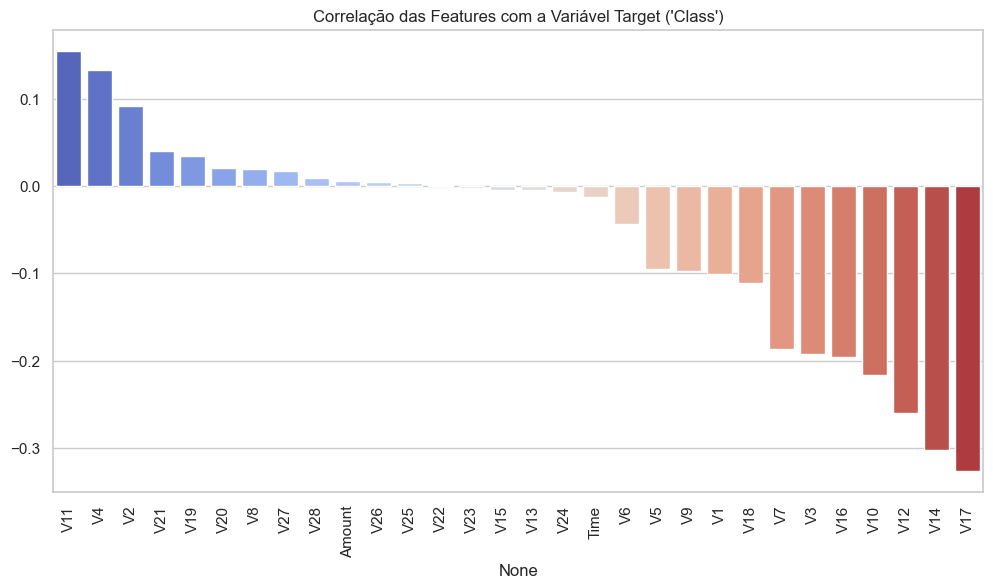

In [10]:
# Calcular a correlação com o target

correlation = transacoes.corr()['Class'].drop('Class').sort_values(ascending=False)

# Exibir um gráfico de barras com as correlações

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation.index, y=correlation.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Correlação das Features com a Variável Target ('Class')")
plt.show()

#### As melhores 20 features

**Vamos usar o SelectKBest para estipularmos quais as melhores features para o modelo.**

In [11]:
# Separando as features e a variável alvo

X = transacoes.drop(columns=['Class'])
y = transacoes['Class']

# Aplicando SelectKBest para selecionar as 10 melhores features

selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Criando um novo DataFrame com as melhores colunas

selected_features = X.columns[selector.get_support()]
X_best = pd.DataFrame(X_new, columns=selected_features, index=X.index)

# Adicionando a coluna 'Class' ao novo DataFrame

X_best['Class'] = y

print("Melhores Features:", selected_features)

Melhores Features: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V27'],
      dtype='object')


### Pré-processamento: 

#### **NOTA**: Em princípio vamos aplicar algoritmos de ML sem balanceamento na base.

- Utilizaremos o **PowerTransformer** devido ao grande número de outliers, **exceto em 'Time'**. <br>
- Em **'Time'** utilizaremos o **MinMaxScaler**.

In [12]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# Criando os escaladores

power_transformer = PowerTransformer(method='yeo-johnson')  # Funciona para valores positivos e negativos
minmax_scaler = MinMaxScaler()

# Aplicando a normalização nas colunas específicas

transacoes['Amount'] = power_transformer.fit_transform(transacoes[['Amount']])
transacoes['Time'] = minmax_scaler.fit_transform(transacoes[['Time']])

transacoes.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.119013,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.128464,0


In [13]:
# Separando X e y

X = transacoes.drop(columns='Class')
y = transacoes['Class']

In [14]:
# Separando em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0,stratify=y)

### XGBoost 

In [15]:
# Criando o modelo XGBoost

modelo_xgb = xgb.XGBClassifier(
    max_depth=9,
    n_estimators=200,
    learning_rate=0.3,
    random_state=0,
    scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])  # Lida com desbalanceamento
)

# Treinando e avaliando o modelo

modelo_xgb.fit(X_train, y_train)
y_pred_xgb = modelo_xgb.predict(X_test)

# Calculando as métricas

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)

# Vusualizando a matriz confusão

confusion_matrix(y_test, y_pred_xgb)

array([[93817,     8],
       [   34,   128]])

In [16]:
# Utilizando as métricas de avaliação

print('Acurácia:', accuracy_score(y_test, y_pred_xgb))
print('Precisão:', precision_score(y_test, y_pred_xgb))
print('Recall:', recall_score(y_test, y_pred_xgb, pos_label=1))

Acurácia: 0.9995531296881484
Precisão: 0.9411764705882353
Recall: 0.7901234567901234


### Random Forest

In [17]:
# Utilizando o Random Forest

clf_RF = RandomForestClassifier(
    max_depth=7,  
    random_state=0,
    criterion='gini',
    n_estimators=100,  
    class_weight='balanced_subsample' 
).fit(X_train, y_train)

y_pred_RF = clf_RF.predict(X_test)

# Vusualizando a matriz confusão

confusion_matrix(y_test, y_pred_RF)

array([[93787,    38],
       [   31,   131]])

In [18]:
# Utilizando as métricas de avaliação

print('Acurácia:', accuracy_score(y_test, y_pred_RF))
print('Precisão:', precision_score(y_test, y_pred_RF))
print('Recall:', recall_score(y_test,y_pred_RF))

Acurácia: 0.9992658559162437
Precisão: 0.7751479289940828
Recall: 0.808641975308642


### Regressão Logística

In [19]:
# Utilizando a Regressão Logística

clfLog = LogisticRegression(random_state=0).fit(X_train, y_train)

# Calculando as métricas

y_predLog = clfLog.predict(X_test)
y_pred_probaLog = clfLog.predict_proba(X_test)[:,1]

# Vusualizando a matriz confusão
confusion_matrix(y_test, y_predLog)

array([[93813,    12],
       [   60,   102]])

In [20]:
# Utilizando as métricas de avaliação

print('Acurácia:', accuracy_score(y_test, y_predLog))
print('Precisão:', precision_score(y_test, y_predLog))
print('Recall:', recall_score(y_test, y_predLog))

Acurácia: 0.9992339366082543
Precisão: 0.8947368421052632
Recall: 0.6296296296296297


### SVC

In [21]:
# Utilizando o SVC

clfSVC = SVC(random_state=0, probability=True).fit(X_train, y_train)

# Fazendo a previsão

y_predSVC = clfSVC.predict(X_test)
y_pred_probaSVC = clfSVC.predict_proba(X_test)[:,1]

# Visualizando a matriz confusão

confusion_matrix(y_test, y_predSVC)

array([[93822,     3],
       [   58,   104]])

In [22]:
# Utilizando as métricas de avaliação

print('Acurácia:', accuracy_score(y_test, y_predSVC))
print('Precisão:', precision_score(y_test, y_predSVC))
print('Recall:', recall_score(y_test, y_predSVC))

Acurácia: 0.9993509740708821
Precisão: 0.9719626168224299
Recall: 0.6419753086419753


### OBSERVAÇÃO: 

Com a base desbalanceada, os três melhores resultados foram:<br>

- **1º Lugar: XGBoost**

    Acurácia: 0.9995531296881484 / Precisão: 0.9411176470588235 / Recall: 0.7901212345679012 

- **2º Lugar: Random Forest**

    Acurácia: 0.9992658559162437 / Precisão: 0.7751479289940828 / Recall: 0.808641975308642

- **3º Lugar: SVC**<br>

    Acurácia: 0.9993509740708821 / Precisão: 0.9719626168224299 / Recall: 0.6419753086419753534234